In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC1D.csv')
btc['datetime'] = pd.to_datetime(btc['datetime'])
starttime = pd.to_datetime("2019-06-27")
btc = btc[(btc['datetime'] >= starttime)]
btc.reset_index(drop=True, inplace=True)
btc

,datetime,open,high,low,close,volume
0,2019-06-27,12933.2,13360.9,10300.0,11148.0,24929.511921
1,2019-06-28,11161.9,12450.0,10723.3,12360.0,13647.202244
2,2019-06-29,12360.0,12436.2,11172.6,11865.1,10943.091229
3,2019-06-30,11865.1,12200.0,10650.0,10752.3,10928.816857
4,2019-07-01,10749.4,11239.0,9900.0,10575.9,14588.405062
...,...,...,...,...,...,...
612,2021-02-28,46163.9,46706.2,43020.0,45245.4,6840.392466
613,2021-03-01,45234.7,49818.1,45046.8,49620.7,7070.920199
614,2021-03-02,49615.3,50225.8,47050.2,48486.2,5796.819654
615,2021-03-03,48495.9,52600.0,48160.0,50400.0,6721.592620


In [3]:
pol = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Matic Historical Data.csv')
pol.rename(columns={'Date': 'datetime', 'Price': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Vol.': 'volume'}, inplace=True)
cols = list(pol.columns)
cols.pop(1)
cols.insert(4, 'close')
pol = pol[cols]
del pol['Change %']
pol['datetime'] = pd.to_datetime(pol['datetime'], format="%b %d, %Y")

endtime = pd.to_datetime("2021-03-04")
pol = pol[(pol['datetime'] <= endtime)]
pol = pol.sort_values(by='datetime', ascending=True)
pol.reset_index(drop=True, inplace=True)
# pol.head()
pol

,datetime,open,high,low,close,volume
0,2019-06-27,0.018,0.022,0.017,0.019,1.56B
1,2019-06-28,0.019,0.021,0.019,0.019,929.60M
2,2019-06-29,0.019,0.027,0.019,0.024,1.79B
3,2019-06-30,0.024,0.027,0.022,0.022,1.52B
4,2019-07-01,0.022,0.023,0.020,0.022,974.46M
...,...,...,...,...,...,...
612,2021-02-28,0.197,0.232,0.173,0.230,1.08B
613,2021-03-01,0.230,0.254,0.217,0.248,956.33M
614,2021-03-02,0.248,0.250,0.213,0.233,526.66M
615,2021-03-03,0.233,0.238,0.219,0.223,353.62M


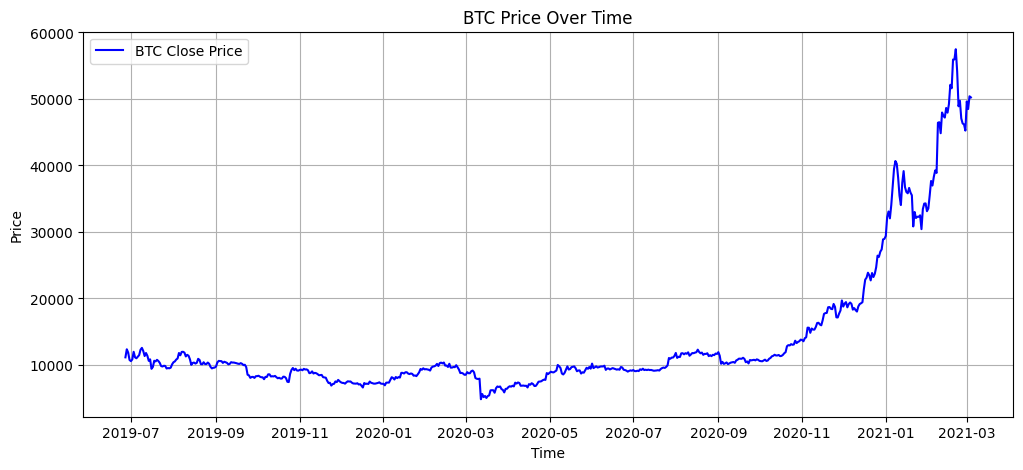

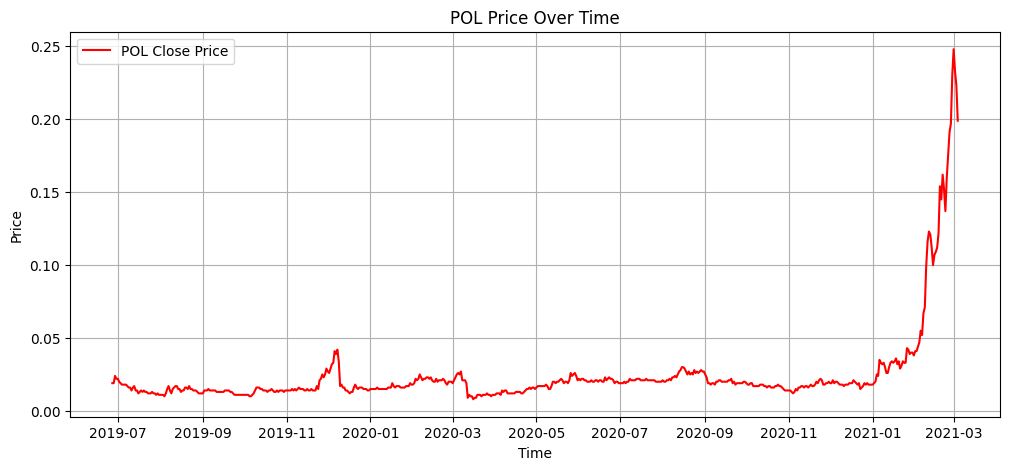

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(btc['datetime'], btc['close'], color='blue', label='BTC Close Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BTC Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(pol['datetime'], pol['close'], color='red', label='POL Close Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("POL Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
merged = pd.merge(btc[['datetime', 'close']], pol[['datetime', 'close']], on='datetime', suffixes=('_btc', '_pol'))

correlation_array = []

for lag in range(1, 13):
    merged[f'btc_lag_{lag}'] = merged['close_btc'].shift(lag)
    corr = merged[[f'btc_lag_{lag}', 'close_pol']].corr().iloc[0, 1]

    correlation_array.append((float(round(corr, 4)), lag))

max_corr = max(correlation_array, key=lambda x: x[0])
optimal_lag = max_corr[1]
print(optimal_lag)

10


In [18]:
merged['btc_lag_curr'] = merged['close_btc'].shift(optimal_lag)
merged['btc_lag_prev'] = merged['close_btc'].shift(optimal_lag + 1)

def signal(row):
  if pd.isna(row['btc_lag_curr']) or pd.isna(row['btc_lag_prev']):
    return 'HOLD'
  elif row['btc_lag_curr'] > row['btc_lag_prev']:
    return 'BUY'
  elif row['btc_lag_curr'] < row['btc_lag_prev']:
    return 'SELL'
  else:
    return 'HOLD'

merged['signal'] = merged.apply(signal, axis=1)
merged.tail(15)

,datetime,close_btc,close_pol,btc_lag_1,btc_lag_2,btc_lag_3,btc_lag_4,btc_lag_5,btc_lag_6,btc_lag_7,btc_lag_8,btc_lag_9,btc_lag_10,btc_lag_11,btc_lag_12,btc_lag_curr,btc_lag_prev,signal
602,2021-02-18,51600.9,0.122,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,44847.5,46502.8,46425.8,38874.9,39257.0,46425.8,38874.9,BUY
603,2021-02-19,55926.9,0.154,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,44847.5,46502.8,46425.8,38874.9,46502.8,46425.8,BUY
604,2021-02-20,55938.7,0.145,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,44847.5,46502.8,46425.8,44847.5,46502.8,SELL
605,2021-02-21,57478.3,0.162,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,44847.5,46502.8,47962.8,44847.5,BUY
606,2021-02-22,54154.8,0.152,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,44847.5,47470.4,47962.8,SELL
607,2021-02-23,48899.8,0.137,54154.8,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,47962.8,47199.9,47470.4,SELL
608,2021-02-24,49727.7,0.160,48899.8,54154.8,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47470.4,48649.7,47199.9,BUY
609,2021-02-25,47061.5,0.176,49727.7,48899.8,54154.8,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,47199.9,47937.1,48649.7,SELL
610,2021-02-26,46314.5,0.191,47061.5,49727.7,48899.8,54154.8,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,48649.7,49218.7,47937.1,BUY
611,2021-02-27,46170.2,0.197,46314.5,47061.5,49727.7,48899.8,54154.8,57478.3,55938.7,55926.9,51600.9,52130.0,49218.7,47937.1,52130.0,49218.7,BUY


In [27]:
#Initial Parameters for backtesting
initial_cash = 1000.0
cash = initial_cash
position = 0.0
portfolio_values = []

for _, row in merged.iterrows():
  price = row['close_pol']
  sig = row['signal']

  if sig == 'BUY' and cash > 0:
    position = cash / price
    cash = 0.0

  elif sig == 'SELL' and position > 0:
    cash = position * price
    position = 0.0

  portfolio_values.append(cash + position * price)

merged['portfolio'] = portfolio_values

merged.head(15)

,datetime,close_btc,close_pol,btc_lag_1,btc_lag_2,btc_lag_3,btc_lag_4,btc_lag_5,btc_lag_6,btc_lag_7,btc_lag_8,btc_lag_9,btc_lag_10,btc_lag_11,btc_lag_12,btc_lag_curr,btc_lag_prev,signal,portfolio
0,2019-06-27,11148.0,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
1,2019-06-28,12360.0,0.019,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
2,2019-06-29,11865.1,0.024,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
3,2019-06-30,10752.3,0.022,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
4,2019-07-01,10575.9,0.022,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
5,2019-07-02,10837.3,0.020,10575.9,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
6,2019-07-03,11979.8,0.019,10837.3,10575.9,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
7,2019-07-04,11148.3,0.018,11979.8,10837.3,10575.9,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
8,2019-07-05,11006.0,0.018,11148.3,11979.8,10837.3,10575.9,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000
9,2019-07-06,11233.5,0.018,11006.0,11148.3,11979.8,10837.3,10575.9,10752.3,11865.1,12360.0,11148.0,NaN,NaN,NaN,NaN,NaN,HOLD,1000.000000


In [29]:
final_value = portfolio_values[-1]
return_pct = (final_value / initial_cash - 1) * 100
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Total return: {return_pct:.2f}%")

Final portfolio value: $1178.87
Total return: 17.89%


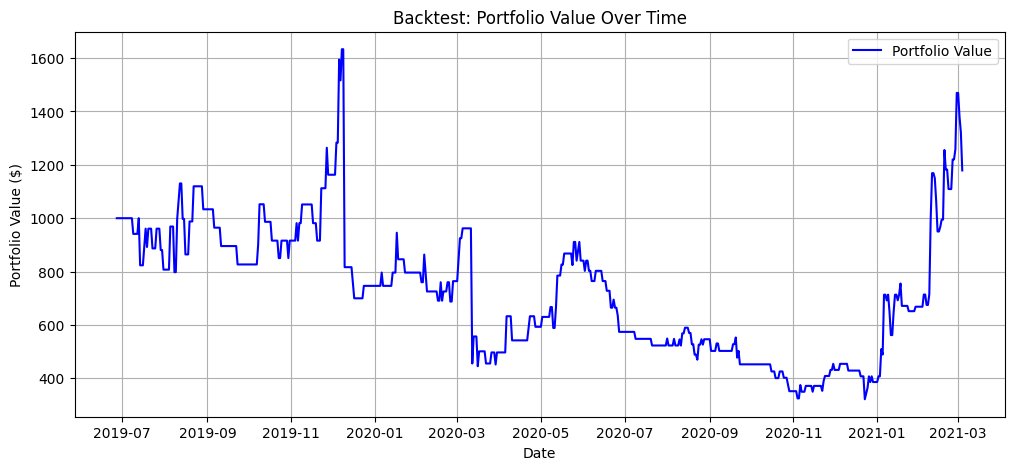

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(merged['datetime'], merged['portfolio'], color='blue', label='Portfolio Value')
plt.title('Backtest: Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()